In [1]:
%matplotlib notebook
# %matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
from params import subject_ids
from params import main_path, data_path
from ipywidgets import widgets
from IPython.display import display, clear_output, Javascript
import mne
from mne.io import Raw
from mne.preprocessing import read_ica
from mne.preprocessing import create_ecg_epochs, create_eog_epochs
import numpy as np
import getpass
import os
# Widget related imports
from traitlets import Unicode
# nbconvert related imports
from nbconvert import get_export_names, export_by_name
from nbconvert.writers import FilesWriter
from nbformat import read, NO_CONVERT
from nbconvert.utils.exceptions import ConversionException
warnings.filterwarnings('ignore')

## Choose subject ID:

In [4]:
name_sel = widgets.Select(
    description='Subject ID:',
    options=subject_ids
)
display(name_sel)

cond_sel = widgets.RadioButtons(
    description='Condition:',
    options=['Eyes closed', 'Eyes open'],
)
display(cond_sel)

In [5]:
%%capture
if cond_sel.value == 'Eyes closed':
    cond = 'ec'
elif cond_sel.value == 'Eyes open':
    cond = 'eo'
subj_ID = name_sel.value

##### Set home directory #########
if getpass.getuser() == 'meg':
    home_dir = '/home/meg'
elif getpass.getuser() == 'dmalt':
    home_dir = '/home/dmalt'
# ------------------------------ #

#### Set path to the data folder (MEG and MEG 2016) ###
main_path = home_dir + '/Dropbox/aut_gamma/'
# --------------------------------------------------- #

data_path = main_path + 'MEG/' + subj_ID
results_path = main_path + 'MEG2016/' + subj_ID
basename = subj_ID + '_rest_raw_tsss_mc_trans_' + cond
fif_file = data_path + '/' + basename + '.fif'
ica_file = results_path + '/' + basename + '-ica.fif'
ica_TC_file = results_path + '/' + basename + '_ica_timecourse.fif'
raw_ica_filename = results_path + '/' + basename + "_ica_raw.fif"
report_path = results_path + '/' + basename + "-report.html"
log_filename = results_path + '/' + basename + '_ica.log'
# Load data
raw = Raw(fif_file, preload=True)
ica = read_ica(ica_file)
ica.labels_ = dict()
ica_TC = Raw(ica_TC_file, preload=True)

In [6]:
# Read log and extract suggested ICs to exclude
ecg_inds_log= []
eog_inds_log = []
muscle_inds_log = []
if os.path.isfile(log_filename):
    log = open(log_filename, 'r')
    log_lines = log.readlines()[:-3]
    log.close()
    import re

    inds = []
    for log_line in log_lines:
        # match = re.findall(r'(\[|,\s?)(\d*)(,\s?|\])', line)
        match = re.search(r'((EOG|ECG|Muscles)).*', log_line)
        if match:
            IC_type = match.group(1)
            exclude =  match.group()
            ICs = re.findall(r'\d+', exclude)
            if ICs:
#                 print ICs
                for entry in ICs:
                    inds.append(int(entry))
                print inds

                if IC_type == 'ECG':
                    ecg_inds_log = inds[:]
                elif IC_type == 'EOG':
                    eog_inds_log = inds[:]
#                 elif IC_type == 'Muscles':
#                     muscle_inds_log = inds
                inds = []

[30, 2]
[41]


In [54]:
# Read log and extract suggested ICs to exclude
ecg_inds_log= []
eog_inds_log = []
muscle_inds_log = []
if os.path.isfile(log_filename):
    log = open(log_filename, 'r')
    log_lines = log.readlines()[:-3]
    log.close()
    import re
    inds = []
    for log_line in log_lines:
        # match = re.findall(r'(\[|,\s?)(\d*)(,\s?|\])', line)
        match = re.search(r'((EOG|ECG|Muscles)).*', log_line)
        if match:
            IC_type = match.group(1)
            exclude =  match.group()
            ICs = re.findall(r'\d+', exclude)
            if ICs:
#                 print ICs
                for entry in ICs:
                    inds.append(int(entry))

                if IC_type == 'ECG':
                    ecg_inds_log = inds[:]
                elif IC_type == 'EOG':
                    eog_inds_log = inds[:]
#                 elif IC_type == 'Muscles':
#                     muscle_inds_log = inds
                inds = []

# Define widgets for ICs selection with defaults from log
# compDict = 
# for iComp in range(ica.n_components):
third_N = ica.n_components_ / 3 + 1
print ica.n_components_
sel_range = range(third_N)

comp_sel_ecg = [ widgets.SelectMultiple(
#     description="(ECG): ",
    options= [ j + third_N * i for j in sel_range if j + third_N * i < ica.n_components_],
    width='60px',
    height=str(18 * third_N) + 'px',
) for i in range(3) ]



comp_sel_eog = [ widgets.SelectMultiple(
#     description="(ECG): ",
    options= [j + third_N * i for j in sel_range if j + third_N * i < ica.n_components_],
    width='60px',
    height=str(18 * third_N) + 'px',
) for i in range(3) ]

comp_sel_emg = [ widgets.SelectMultiple(
#     description="(ECG): ",
    options= [j + third_N * i for j in sel_range if j + third_N * i < ica.n_components_],
    width='60px',
    height=str(18 * third_N) + 'px',
) for i in range(3) ]

for i in range(3):
    comp_sel_ecg[i].value = value=[k for k in ecg_inds_log if third_N * i < k < third_N * (i + 1) ]
    comp_sel_eog[i].value = value=[k for k in eog_inds_log if third_N * i < k < third_N * (i + 1) ]
    comp_sel_emg[i].value = []


    
def on_button_clicked(b):
    if b.sel == 'ecg':
        comp_sel_ecg[b.num].value = []
    elif b.sel == 'eog':
        comp_sel_eog[b.num].value = []
    elif b.sel == 'emg':
        comp_sel_emg[b.num].value = []
        
from ipywidgets.widgets import HBox, VBox
buttons_ecg = [widgets.Button(description='Clear ECG ' + str(i + 1), width='85px', sel='ecg', num=i) for i in range(3)]
buttons_eog = [widgets.Button(description='Clear EOG ' + str(i + 1), width='85px', sel='eog', num=i) for i in range(3)]
buttons_emg = [widgets.Button(description='Clear EMG ' + str(i + 1), width='85px', sel='emg', num=i) for i in range(3)]

header_ecg = widgets.HTML(value='<h2>ECG components</h2>')
header_eog = widgets.HTML(value='<h2>EOG components</h2>')
header_emg = widgets.HTML(value='<h2>EMG components</h2>')

box_ecg = VBox([header_ecg] + [HBox(buttons_ecg)] + [HBox(comp_sel_ecg)])
box_eog = VBox([header_eog] +[HBox(buttons_eog)] + [HBox(comp_sel_eog)])
box_emg = VBox([header_emg] +[HBox(buttons_emg)] + [HBox(comp_sel_emg)])
box_ecg.border_style = 'dotted'
box_ecg.border_radius = '14px'

box_eog.border_style = 'dotted'
box_eog.border_radius = '14px'
box_emg.border_style = 'dotted'
box_emg.border_radius = '14px'
# box_ecg.background_color ='cyan'
box = HBox([box_ecg, box_eog, box_emg])

55


## Cell below opens an html report in a web-browser

In [8]:
%%bash -s "$report_path"
firefox -new-window $1

## Keyboard shortcuts for raw file viewer
--------------
|Command               | Action                       |
|----------------------|------------------------------|
|<b>left_arrow</b>    | navigate left |
|<b>right_arrow</b>   | navigate right |
|<b>down_arrow</b>    | navigate channels down |
|<b>up_arrow</b>      | navigate channels up     |
|<b>-</b>             | scale down               |
|<b>+ or =</b>        | scale up                 |
|<b>Home</b>        | Reduce the time shown per view   |
|<b>End</b>        | Icrease the time shown per view    |
|<b>Page down</b>        | Reduce the number of channels per view   |
|<b>Page up</b>        | Increse the number of channels per view  |
|<b>F11 </b>        | Toggle fullscrean mode |

### Mouse controls
----
|Command | Action | 
| --- | --- |
|<b>click on data:</b>      | mark bad channel     |
|<b>click elsewhere in the plot:</b>    | vertical line at a time instant    |
|<b>click channel name:</b>    | mark bad channel    |

In [9]:
# %%capture
freq_range = widgets.FloatRangeSlider(description='Bandpass filter range (Hz):', value=(0.,40.))
display(freq_range)

Low-pass filtering at 29 Hz


<IPython.core.display.Javascript object>


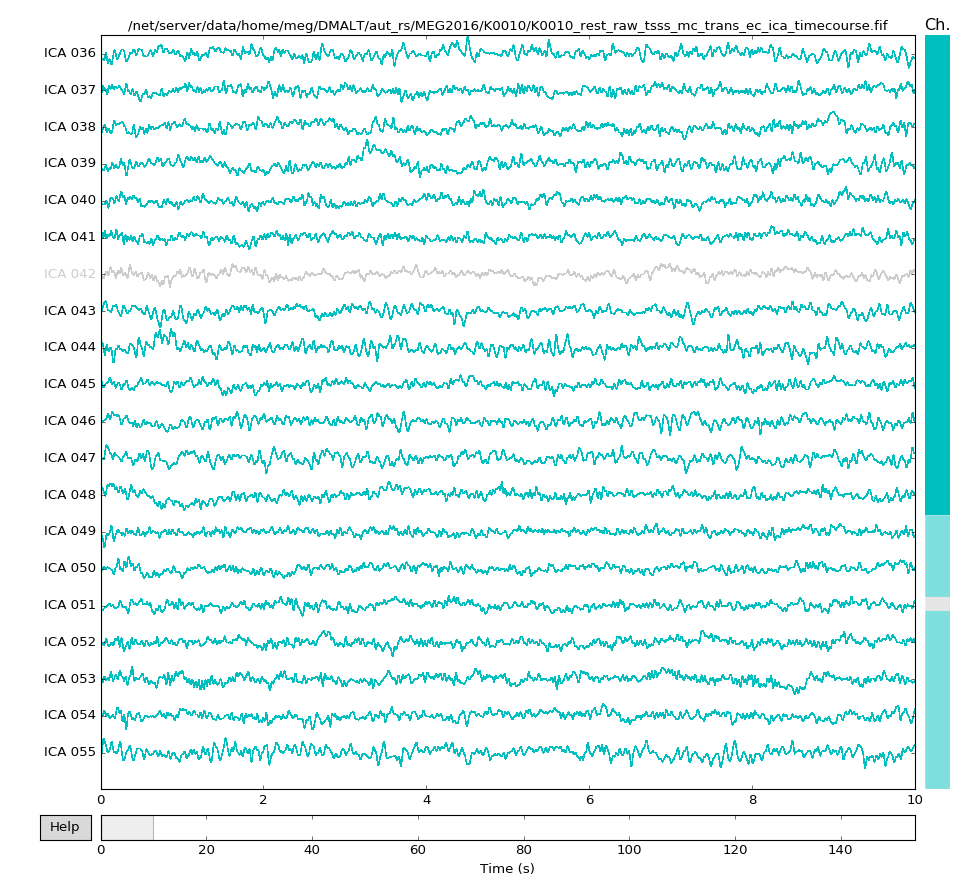

Length of raw file is 154.0 seconds
['ECG exclude suggested: [30, 2]\n', 'EOG exclude suggested: [41]\n', '\n']


In [44]:
# %matplotlib notebook
l_freq = freq_range.value[0]
h_freq = freq_range.value[1]
ica_plot = ica_TC.copy()
ica_plot.filter(l_freq=l_freq, h_freq=h_freq)
fig = ica_plot.plot(bgcolor='w', scalings={'misc': 4}, color={'misc':'c'})
fig.set_figwidth(12)
fig.set_figheight(11)
print('Length of raw file is %.1f seconds' %  round(raw.times[-1], 1))
f = open(results_path + '/' + basename + '_ica.log', 'r')
lines = f.readlines()
f.close()
print lines[2:-3]

In [55]:
print   "Use ctrl or shift for multiple selection"
for i in range(3):
    buttons_ecg[i].on_click(on_button_clicked)
    buttons_eog[i].on_click(on_button_clicked)
    buttons_emg[i].on_click(on_button_clicked)
display(box)

Use ctrl or shift for multiple selection


<IPython.core.display.Javascript object>


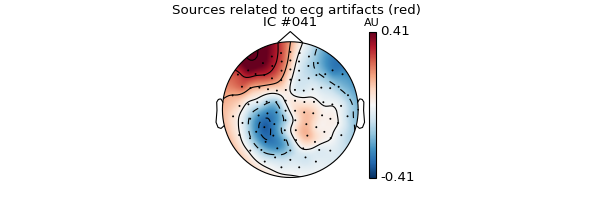

<IPython.core.display.Javascript object>


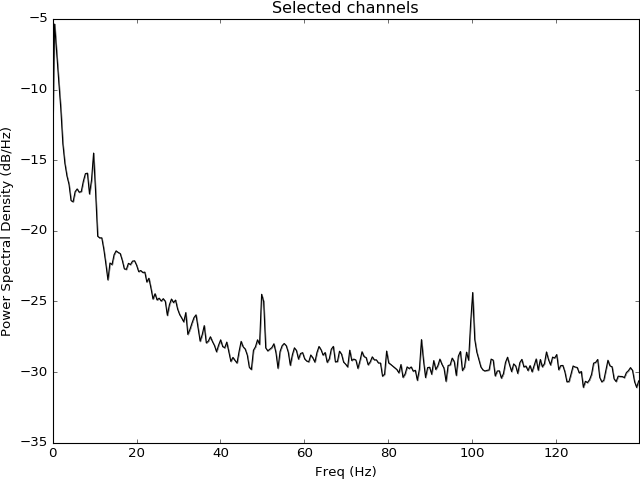

Effective window size : 2.048 (s)


<IPython.core.display.Javascript object>


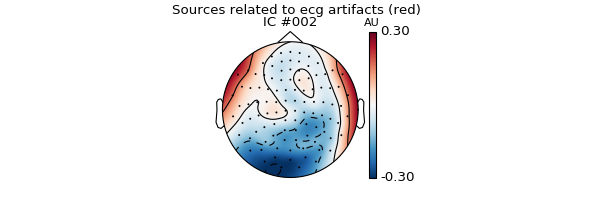

<IPython.core.display.Javascript object>


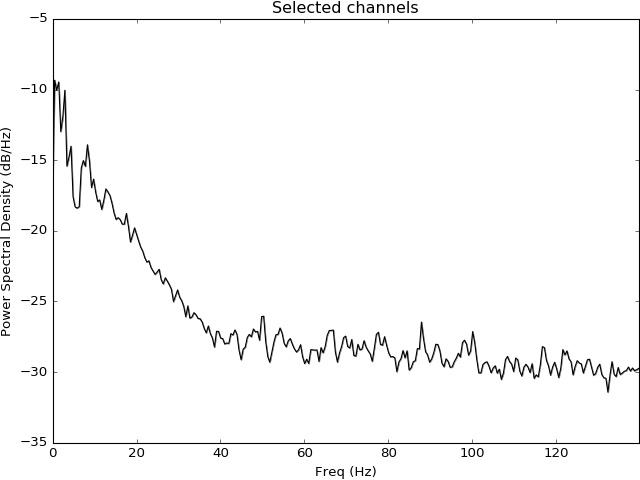

Effective window size : 2.048 (s)


<IPython.core.display.Javascript object>


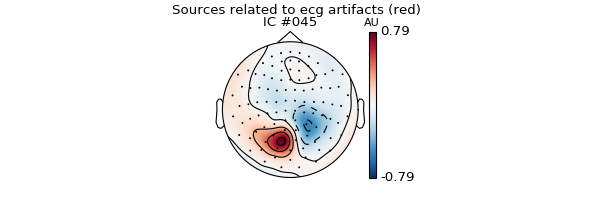

<IPython.core.display.Javascript object>


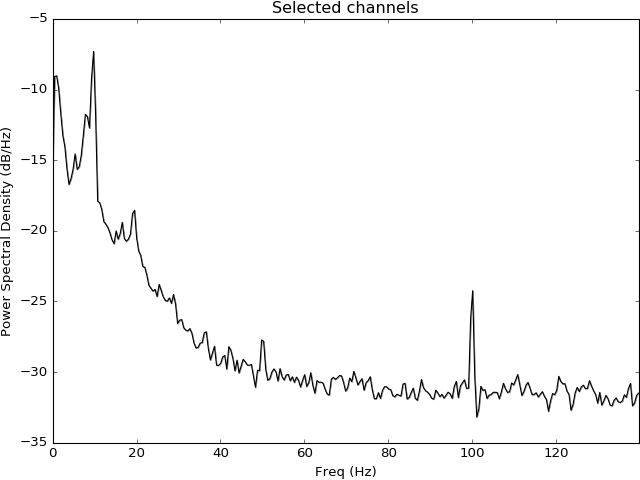

Effective window size : 2.048 (s)


<IPython.core.display.Javascript object>


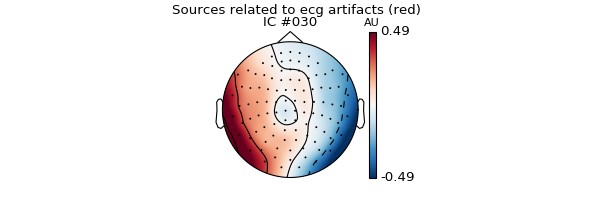

<IPython.core.display.Javascript object>


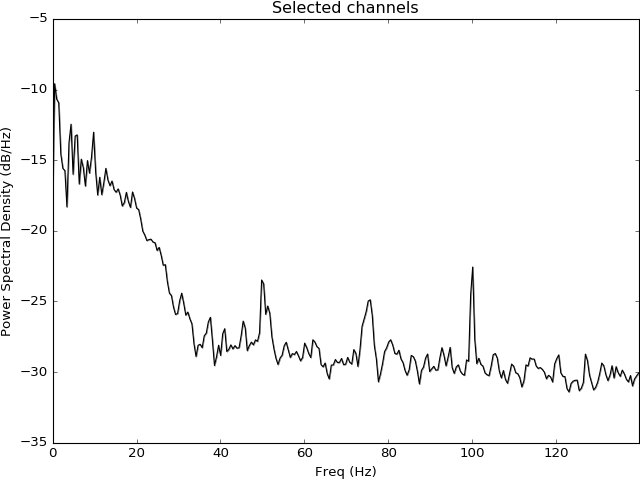

Effective window size : 2.048 (s)


In [49]:
# %matplotlib inline
ICA_title = 'Sources related to %s artifacts (red)'
is_show = False
ecg_inds = []
eog_inds = []
emg_inds = []
for i in range(3):
    ecg_inds.extend(list(comp_sel_ecg[i].value))
    eog_inds.extend(list(comp_sel_eog[i].value))
    emg_inds.extend(list(comp_sel_emg[i].value))
picks = ecg_inds + eog_inds + emg_inds 
picks = list(set(picks))
ICs_header = widgets.HTML('<h2>Selected ICs: ' + str(picks) + '</h2>')
for iPick in picks:
    fig1 = ica.plot_components(iPick, title=ICA_title % 'ecg', colorbar=True, show=is_show)
    fig1.set_label('IC #' + str(iPick))
    fig2 = ica_TC.plot_psd(tmax=None, picks=iPick, fmax=140, show=False)
    fig2.set_label('IC #' + str(iPick))
#     fig.set_figwidth(6)
#     fig.set_figheight(3)
display(ICs_header)
# ecg_inds.

## Apply ica solution to raw data and save the result

In [31]:
%%capture
ica.exclude = picks
raw_ica = ica.apply(raw, copy=True)
raw_ica.save(raw_ica_filename, overwrite=True)
ica.save(ica_file)
ica.exclude

[41, 2, 30]

### Write log

In [32]:
f = open(results_path + '/' + basename + '_ica.log', 'r')
lines = f.readlines()
f.close()
f = open(results_path + '/' + basename + '_ica.log', 'w')
# lines = f.readlines()
f.writelines(lines[:-3])
f.write('ECG exclude final: ' + str(ecg_inds) + '\n')
f.write('EOG exclude final: ' + str(eog_inds) + '\n')
f.write('Muscles exclude: []' + '\n')
f.close()
lines

['Data rank after SSS: N/A\n',
 'Sampling freq: 1000.0\n',
 'ECG exclude suggested: [30, 2]\n',
 'EOG exclude suggested: [41]\n',
 '\n',
 'ECG exclude final: [0]\n',
 'EOG exclude final: [0]\n',
 'Muscles exclude: []\n']

In [56]:
notebook_name = widgets.Text()

js = """IPython.notebook.kernel.widget_manager.get_model('%s').then(function(model) {
    model.set('value', IPython.notebook.notebook_name);
    model.save();
});
""" % notebook_name.model_id
display(Javascript(data=js))

<IPython.core.display.Javascript object>

In [57]:
filename = notebook_name.value
exporter_names = widgets.Dropdown(options=get_export_names(), value='html')
export_button = widgets.Button(description="Export")
download_link = widgets.HTML(visible=False)

file_writer = FilesWriter()

def export(name, nb):
    
    # Get a unique key for the notebook and set it in the resources object.
    notebook_name = name[:name.rfind('.')]
    resources = {}
    resources['unique_key'] = notebook_name
    resources['output_files_dir'] = '%s_files' % notebook_name

    # Try to export
    try:
        output, resources = export_by_name(exporter_names.value, nb)
    except ConversionException as e:
        download_link.value = "<br>Could not export notebook!"
    else:
        write_results = file_writer.write(output, resources, notebook_name=notebook_name)
    
        download_link.value = "<br>Results: <a href='file://{filename}'><i>\"{filename}\"</i></a>".format(filename=write_results)
        download_link.visible = True
        
def handle_export(widget):
    with open(filename, 'rb') as f:
        export(results_path + '/' + cond + '_' + filename , read(f, NO_CONVERT))
        
export_button.on_click(handle_export)

display(exporter_names, export_button, download_link)